In [ ]:
import pandas as pd                    
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import torch
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split

import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torchvision import transforms

import torchvision.models as models

from sklearn.linear_model import LogisticRegression
from sklearn.utils import shuffle
import cv2
import os

import pickle

from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score

In [2]:
df_DC = pd.read_csv('/kaggle/input/micromobility-lane-recognition-dataset/MLRD/labels/WashingtonDC/washingtonDC-01.csv')

print(f'We have {len(df_DC.columns)} Features')
_ = [print(col, 'Type:', df_DC[col].dtype) for col in df_DC.columns]

We have 18 Features
frame Type: int64
road Type: int64
sidewalk Type: int64
bikelane Type: int64
asphalt Type: int64
concrete Type: int64
cobblestone Type: int64
dirt Type: int64
grass Type: int64
day Type: int64
night Type: int64
indoor Type: int64
sunny Type: int64
cloudy Type: int64
raining Type: int64
on Type: float64
off Type: float64
Unnamed: 17 Type: float64


In [3]:
df_DC.head()

,frame,road,sidewalk,bikelane,asphalt,concrete,cobblestone,dirt,grass,day,night,indoor,sunny,cloudy,raining,on,off,Unnamed: 17
0,7,1,0,0,1,0,0,0,0,1,0,0,0,1,0,NaN,NaN,NaN
1,8,1,0,0,1,0,0,0,0,1,0,0,0,1,0,NaN,NaN,NaN
2,9,1,0,0,1,0,0,0,0,1,0,0,0,1,0,NaN,NaN,NaN
3,10,1,0,0,1,0,0,0,0,1,0,0,0,1,0,NaN,NaN,NaN
4,11,1,0,0,1,0,0,0,0,1,0,0,0,1,0,NaN,NaN,NaN


In [4]:
columns = df_DC.columns.tolist()
print('Columns:', columns)

Columns: ['frame', 'road', 'sidewalk', 'bikelane', 'asphalt', 'concrete', 'cobblestone', 'dirt', 'grass', 'day', 'night', 'indoor', 'sunny', 'cloudy', 'raining', 'on', 'off', 'Unnamed: 17']


## Organize the Dataset into One CSV File

The Dataset is so messy, that we have to extract all image paths and put them into one new organized csv file

### Extract all Image Directories Paths

In [5]:
# You Can Edit this to get the frames directory in the dataset directory                                                                                
frames_path = '/kaggle/input/micromobility-lane-recognition-dataset/MLRD/frames'
# You Can Edit this to get the labels directory in the dataset directory
labels_path = '/kaggle/input/micromobility-lane-recognition-dataset/MLRD/labels'


# Dublin01
dublin_dirs = []
curr_dir = 'Dublin01'
input_image_path = os.path.join(frames_path, curr_dir)
input_label_path = os.path.join(labels_path, curr_dir)
dublin_dirs = [os.path.join(input_image_path, d) for d in os.listdir(input_image_path) if d != 'journeys']

curr_dir = 'journeys'
journey_dirs = []
input_image_path = os.path.join(input_image_path, curr_dir)
for d1 in os.listdir(input_image_path):
    d1_path = os.path.join(input_image_path, d1)
    for d2 in os.listdir(d1_path):
        d2_path = os.path.join(d1_path, d2)
        for d3 in os.listdir(d2_path):
            d3_path = os.path.join(d2_path, d3)
            journey_dirs.append(d3_path)

dublin_dirs.extend(journey_dirs)


#Northampton02
northampton_dirs = []
northampton_dirs.append(os.path.join(frames_path, 'Northampton02/Northampton02-vid-14-15-17'))

#Northampton04
curr_dir = os.path.join(frames_path, 'Northampton04')
for d in os.listdir(curr_dir):
    d_path = os.path.join(curr_dir, d)
    northampton_dirs.append(d_path)

#Paris
curr_dir = os.path.join(frames_path, 'Paris')
paris_dirs = []
paris_dirs.append(os.path.join(curr_dir, 'Paris_Dott02'))
paris_dirs.append(os.path.join(curr_dir, 'Paris_Dott03'))

#Singapore
curr_dir = os.path.join(frames_path, 'Singapore/Singapore')
singapore_dir = []
singapore_dir.append(curr_dir)

#Stockholm
curr_dir = os.path.join(frames_path, 'Stockholm')
stockholm_dirs = [os.path.join(curr_dir, d) for d in os.listdir(curr_dir)]

#WashingtonDC
curr_dir = os.path.join(frames_path, 'WashingtonDC/washingtonDC-01')
DC_dir = []
DC_dir.append(curr_dir)


all_dir_paths = []
all_dir_paths.extend(dublin_dirs)
all_dir_paths.extend(northampton_dirs)
all_dir_paths.extend(paris_dirs)
all_dir_paths.extend(singapore_dir)
all_dir_paths.extend(stockholm_dirs)
all_dir_paths.extend(DC_dir)

### Create a New Directory for the Organzied Dataset

In [6]:
root_dir = os.getcwd()
os.makedirs(os.path.join(root_dir, 'Dataset'), exist_ok=True)

### Extract Image Paths

In [7]:
def extract_images(dir_path):
    images = [f for f in os.listdir(dir_path) if f.endswith('png')]
    return images

### Drop NaN Columns + Extract Labels                                        
  
  

In [8]:
def extract_labels(d_path):
    csv_file_path = d_path.replace('frames', 'labels') + '.csv'
    df_labels = pd.read_csv(csv_file_path)

    if 'frame' in df_labels.columns:
        df_labels.set_index('frame', inplace=True)
        # Reset index to start from 1
        df_labels.index = range(1, len(df_labels) + 1)

    # Drop 'frame' column if it exists
    if 'frame' in df_labels.columns:
        df_labels.drop('frame', axis=1, inplace=True)

    # Drop columns with NaN values
    df_labels.dropna(axis=1, inplace=True)

    # Convert each row of DataFrame into a list of labels
    all_labels = df_labels.values.tolist()

    return all_labels

In [9]:
def combine_path_and_labels(image_paths, label_lists):
    combined_data = []

    for path, labels in zip(image_paths, label_lists):
        combined_data.append([path] + labels)

    return combined_data

In [10]:
output_rows = []
# city_image_counts = {city: 0 for city in cities}

for d_num, d_path in enumerate(all_dir_paths, start=1):

    # Extract images
    images_names = extract_images(d_path)
    images_paths = [os.path.join(d_path, image_name) for image_name in images_names]

    # Extract labels
    all_labels = extract_labels(d_path)

    # Combine each image path + labels
    output_rows_per_path = combine_path_and_labels(images_paths, all_labels)

    # Append to output_rows
    output_rows.extend(output_rows_per_path)

    print(f"Processing complete for directory {d_num} / {len(all_dir_paths)}")

Processing complete for directory 1 / 65
Processing complete for directory 2 / 65
Processing complete for directory 3 / 65
Processing complete for directory 4 / 65
Processing complete for directory 5 / 65
Processing complete for directory 6 / 65
Processing complete for directory 7 / 65
Processing complete for directory 8 / 65
Processing complete for directory 9 / 65
Processing complete for directory 10 / 65
Processing complete for directory 11 / 65
Processing complete for directory 12 / 65
Processing complete for directory 13 / 65
Processing complete for directory 14 / 65
Processing complete for directory 15 / 65
Processing complete for directory 16 / 65
Processing complete for directory 17 / 65
Processing complete for directory 18 / 65
Processing complete for directory 19 / 65
Processing complete for directory 20 / 65
Processing complete for directory 21 / 65
Processing complete for directory 22 / 65
Processing complete for directory 23 / 65
Processing complete for directory 24 / 65
P

### Create a New CSV File

In [11]:
# Load and preprocess data
organized_dataset_csv = os.path.join(root_dir, 'Dataset/Organized_dataset.csv')

### Define the New Columns

In [14]:
new_labels= columns[1:-3]
new_columns = ['image_path'] + new_labels

### Write the Dataset into the New CSV File

In [15]:
output_df = pd.DataFrame(output_rows, columns=new_columns)
output_df.to_csv(organized_dataset_csv, index=False)

### Read the New CSV File

In [16]:
df = pd.read_csv(organized_dataset_csv)

### Show the new Dataset

In [17]:
df.head()

,image_path,road,sidewalk,bikelane,asphalt,concrete,cobblestone,dirt,grass,day,night,indoor,sunny,cloudy,raining
0,/kaggle/input/micromobility-lane-recognition-d...,1,0,0,1,0,0,0,0,1,0,0,1,0,0
1,/kaggle/input/micromobility-lane-recognition-d...,1,0,0,1,0,0,0,0,1,0,0,1,0,0
2,/kaggle/input/micromobility-lane-recognition-d...,1,0,0,1,0,0,0,0,1,0,0,1,0,0
3,/kaggle/input/micromobility-lane-recognition-d...,1,0,0,1,0,0,0,0,1,0,0,1,0,0
4,/kaggle/input/micromobility-lane-recognition-d...,1,0,0,1,0,0,0,0,1,0,0,1,0,0


## Get to Know the Dataset - EDA

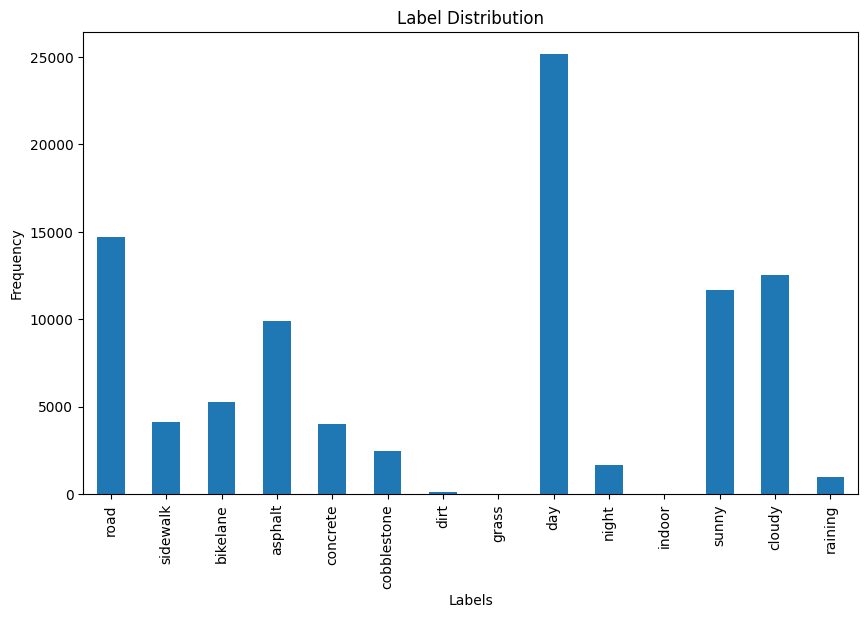

In [24]:
# Bar Chart for Label Distribution                    
label_columns = new_labels
label_counts = df[label_columns].sum()

plt.figure(figsize=(10, 6))
label_counts.plot(kind='bar')
plt.title('Label Distribution')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.show()


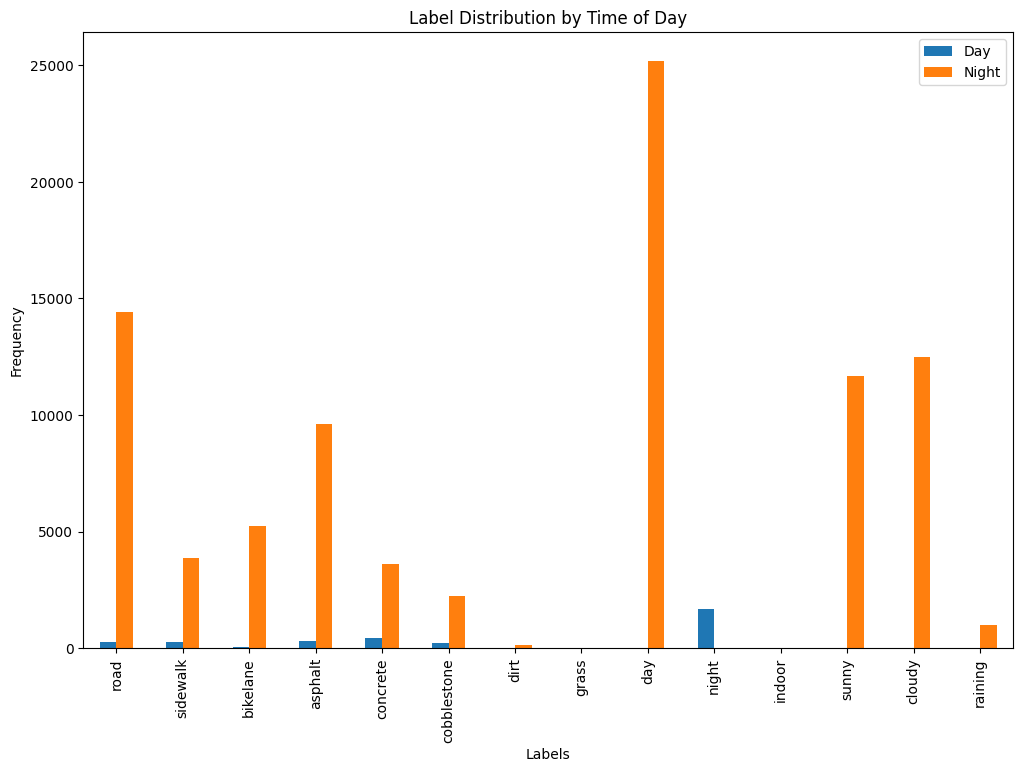

In [25]:
# Grouped Bar Chart for Time of Day

day_night_counts = df.groupby('day')[label_columns].sum().T
night_counts = df.groupby('night')[label_columns].sum().T

day_night_counts.plot(kind='bar', figsize=(12, 8))
plt.title('Label Distribution by Time of Day')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.legend(['Day', 'Night'])
plt.show()

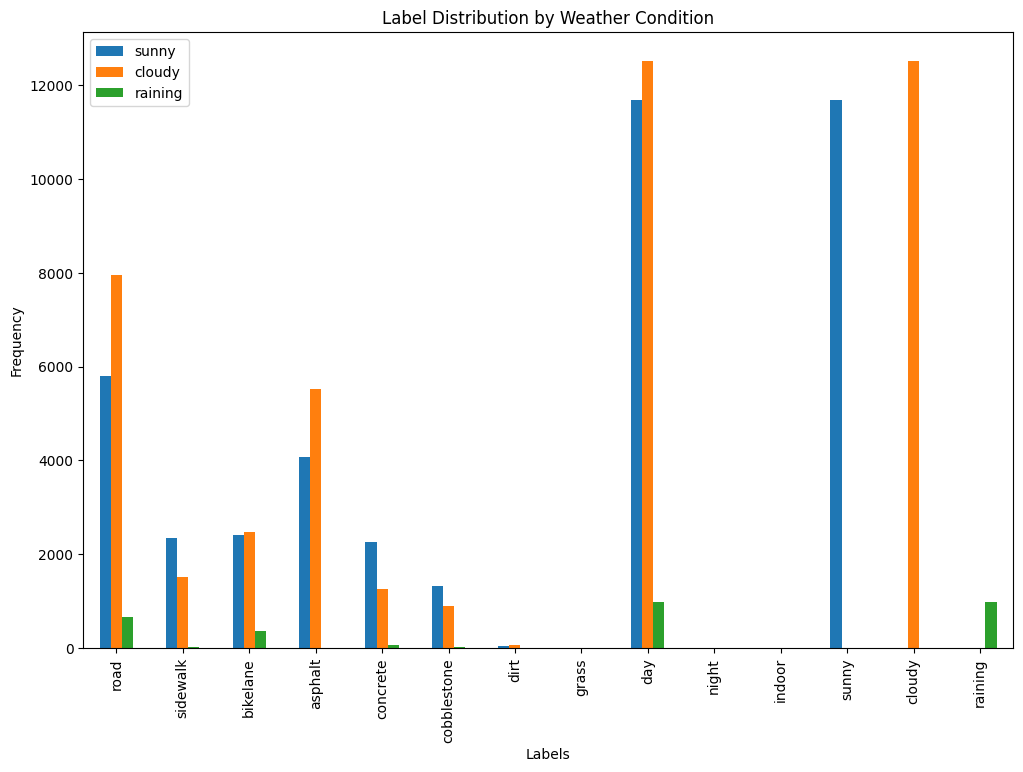

In [27]:
# Grouped Bar Chart for Weather Condition

weather_conditions = ['sunny', 'cloudy', 'raining']
weather_counts = {condition: df[df[condition] == 1][label_columns].sum() for condition in weather_conditions}

weather_df = pd.DataFrame(weather_counts)
weather_df.plot(kind='bar', figsize=(12, 8))
plt.title('Label Distribution by Weather Condition')
plt.xlabel('Labels')
plt.ylabel('Frequency')
plt.legend(weather_conditions)
plt.show()

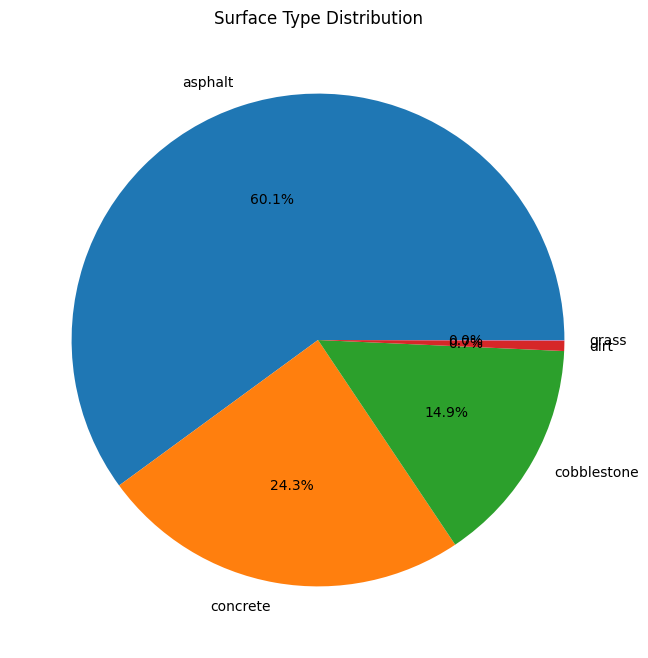

In [28]:
# Pie Chart for Sufrace Type Distribution

surface_labels = ['asphalt', 'concrete', 'cobblestone', 'dirt', 'grass']
surface_counts = df[surface_labels].sum()

plt.figure(figsize=(8, 8))
surface_counts.plot(kind='pie', autopct='%1.1f%%')
plt.title('Surface Type Distribution')
plt.ylabel('')
plt.show()

In [94]:
df = pd.read_csv('../Dataset/Organized_dataset.csv')

## Data Analysis

#### Analyze Distribution

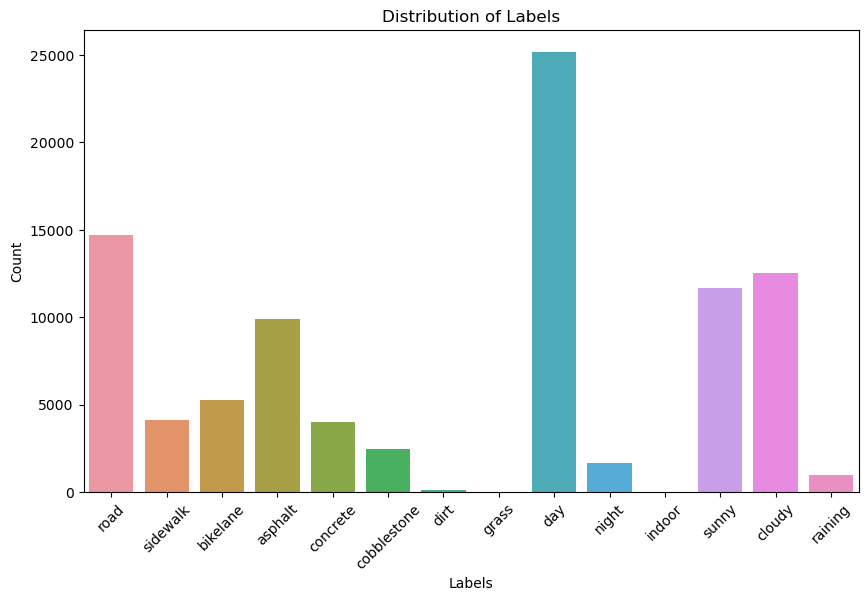

In [85]:
# Plot label distribution
plt.figure(figsize=(10, 6))
sns.barplot(x=label_counts.index, y=label_counts.values)
plt.title('Distribution of Labels')
plt.xlabel('Labels')
plt.ylabel('Count')
plt.xticks(rotation=45)
plt.show()

### Label Co-Occurrence Matrix

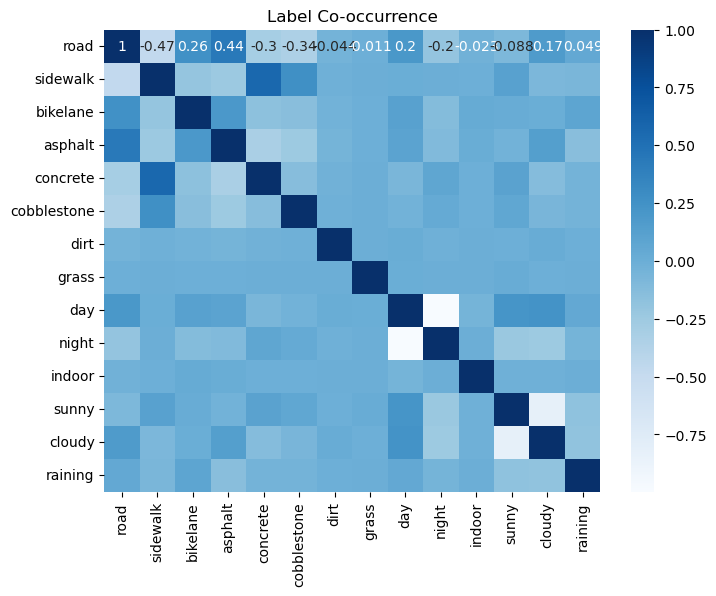

In [86]:
cooccurrence_matrix = df[label_columns].corr()
# Plot label co-occurrence heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cooccurrence_matrix, annot=True, cmap='Blues')
plt.title('Label Co-occurrence')
plt.show()

### Plot Some Images with Their Labels

In [116]:
dataset_path = '/kaggle/input/micromobility-lane-recognition-dataset/MLRD'                    
  
frames_path = os.path.join(dataset_path, 'frames')
labels_path = os.path.join(dataset_path, 'labels')
images_path = '../Images'

filenames = [
    'Dublin01-GH010157-000004_anon.png',
    'Paris-Paris_Dott02-000005_anon.png',
    'Singapore-Singapore-000023_anon.png',
    'Stockholm-GH010128-000002_anon.png'
]

transformed_filenames = [filename.replace('-', '/') for filename in filenames]

image_paths_in_dataset = [os.path.join(frames_path, filename) for filename in transformed_filenames]

image_paths_in_repo = [os.path.join(images_path, filename) for filename in  filenames]

In [117]:
def extract_labels_per_image(image_path, df):                                        
    row = df[df['image_path'] == image_path]
    if len(row) == 0:
        return None
    
    labels = []
    for col in label_columns:
        if row[col].values[0] == 1:
            labels.append(col)
    
    return labels

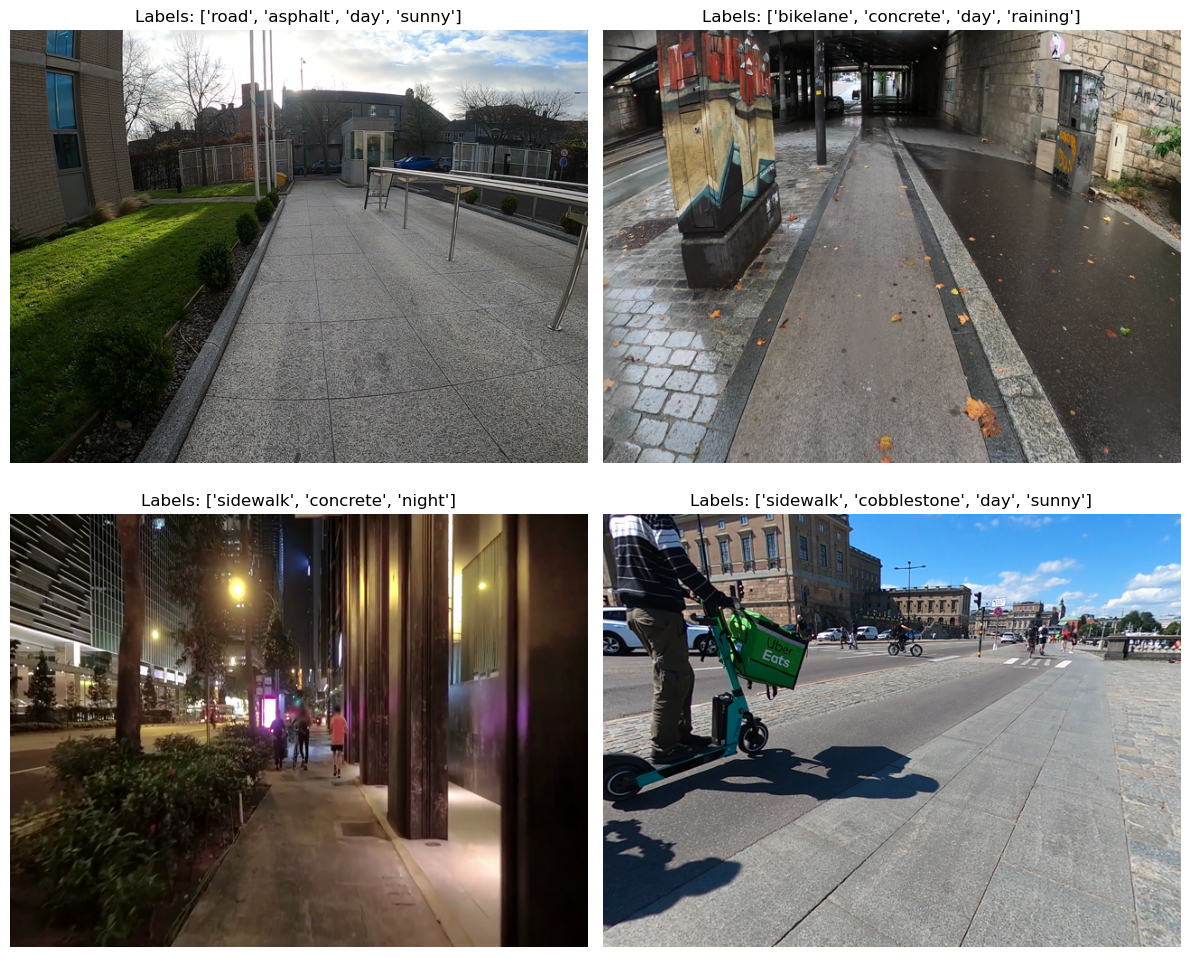

In [122]:
# Prepare to plot two images per row in a single plot
fig, axes = plt.subplots(nrows=2, ncols=2, figsize=(12, 10))  # Adjust figsize as needed
axes = axes.flatten()  # Flatten the 2D array of axes for easier iteration

# Plot images with formatted labels (two images per row)
for idx, (d_image_path, r_image_path) in enumerate(zip(image_paths_in_dataset, image_paths_in_repo)):
    # Extract labels
    labels = extract_labels_per_image(d_image_path, df)
    
    # Load and display the image
    img = Image.open(r_image_path)
    
    # Plot on the respective subplot
    axes[idx].imshow(img)
    axes[idx].set_title(f"Labels: {labels}")
    axes[idx].axis('off')

# Adjust layout and display plot
plt.tight_layout()
plt.show()

## Prepare the Data before Passing it to the Models

### For CNN and ResNet Models

In [18]:
# Custom dataset class
class ImageDataset(Dataset):
    def __init__(self, dataframe, transform=None):
        self.dataframe = dataframe
        self.transform = transform
        
    def __len__(self):
        return len(self.dataframe)
    
    def __getitem__(self, idx):
        img_name = self.dataframe.iloc[idx, 0]
        image = Image.open(img_name).convert('RGB')
        labels = self.dataframe.iloc[idx, 1:].values.astype('float32')
        
        if self.transform:
            image = self.transform(image)                    
  
        
        return {'image': image, 'labels': torch.tensor(labels)}

### Split the dataset into 80% Training and 20% Testing

In [19]:
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)

In [20]:
transform = transforms.Compose([
    transforms.Resize((128, 128)),
    transforms.ToTensor(),
    transforms.Normalize((0.5,), (0.5,))
])

### Transform the Dataset

In [21]:
train_dataset = ImageDataset(train_df, transform=transform)
test_dataset = ImageDataset(test_df, transform=transform)

### Define some hyperparameters

In [22]:
batch_size = 32
img_size = (224, 224)
epochs = 10

### Load the Transformed Dataset

In [23]:
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=4)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False, num_workers=4)

## Declare the Models

## Model 1: CNN

In [2]:
###############################
import torch.nn as nn

In [3]:
class SimpleCNN(nn.Module):
    def __init__(self):
        super(SimpleCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.fc1 = nn.Linear(64 * 32 * 32, 128)
        self.fc2 = nn.Linear(128, 14)
        self.sigmoid = nn.Sigmoid()
    
    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(-1, 64 * 32 * 32)
        x = F.relu(self.fc1(x))
        x = self.sigmoid(self.fc2(x))
        return x

In [22]:
cnn_model = SimpleCNN()
criterion = nn.BCELoss()

## Model 2: ResNet

In [23]:
resnet_model = models.resnet50(pretrained=True)
num_ftrs = resnet_model.fc.in_features
resnet_model.fc = nn.Sequential(
    nn.Linear(num_ftrs, 14),
    nn.Sigmoid()
)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


## Model 3: VGG16

In [24]:
vgg16_model = models.vgg16(pretrained=True)
num_ftrs = vgg16_model.classifier[6].in_features
vgg16_model.classifier[6] = nn.Sequential(
    nn.Linear(num_ftrs, 14),
    nn.Sigmoid()
)

/opt/conda/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=VGG16_Weights.IMAGENET1K_V1`. You can also use `weights=VGG16_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


### Declare the Optimizers

In [25]:
cnn_optimizer = optim.Adam(cnn_model.parameters(), lr=0.001)
resnet_optimizer = optim.Adam(resnet_model.parameters(), lr=0.001)
vgg16_optimizer = optim.Adam(vgg16_model.parameters(), lr=0.001)

### Define Early Stopping Class - To Prevent Overfitting

In [26]:
class EarlyStopping:
    def __init__(self, patience=3, verbose=False):
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')

    def __call__(self, val_loss, model):
        score = -val_loss

        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        elif score < self.best_score:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
        torch.save(model.state_dict(), 'checkpoint.pt')
        self.val_loss_min = val_loss


## Train the Models

In [27]:
def train_model(model, dataloader, criterion, optimizer, num_epochs=10, threshold=0.5, patience=3):
    train_losses = []
    val_losses = []
    train_accuracies = []
    val_accuracies = []

    early_stopping = EarlyStopping(patience=patience, verbose=True)
    
    for epoch in range(num_epochs):
        # Training phase
        model.train()
        running_loss = 0.0
        correct_predictions = 0
        total_predictions = 0
        
        for batch in dataloader['train']:
            images = batch['image']
            labels = batch['labels'].float()  # Ensure labels are float32
            
            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()
            
            running_loss += loss.item()
            
            # Calculate training accuracy
            preds = outputs > threshold
            correct_predictions += (preds == labels).sum().item()
            total_predictions += labels.numel()
        
        train_loss = running_loss / len(dataloader['train'])
        train_losses.append(train_loss)
        train_accuracy = correct_predictions / total_predictions
        train_accuracies.append(train_accuracy)
        
        # Validation phase
        model.eval()
        val_loss = 0.0
        correct_predictions = 0
        total_predictions = 0
        
        with torch.no_grad():
            for batch in dataloader['val']:
                images = batch['image']
                labels = batch['labels'].float()  # Ensure labels are float32
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                
                # Calculate validation accuracy
                preds = outputs > threshold
                correct_predictions += (preds == labels).sum().item()
                total_predictions += labels.numel()
        
        val_loss = val_loss / len(dataloader['val'])
        val_losses.append(val_loss)
        val_accuracy = correct_predictions / total_predictions
        val_accuracies.append(val_accuracy)
        
        print(f'Epoch {epoch+1}, Train Loss: {train_loss}, Train Accuracy: {train_accuracy}, Val Loss: {val_loss}, Val Accuracy: {val_accuracy}')
        
        early_stopping(val_loss, model)
        
        if early_stopping.early_stop:
            print("Early stopping triggered")
            break
    
    model.load_state_dict(torch.load('checkpoint.pt'))
    return train_losses, val_losses, train_accuracies, val_accuracies

In [28]:
dataloader = {'train': train_loader, 'val': test_loader}

### Train Model 1 - CNN

In [ ]:
cnn_train_losses, cnn_val_losses, cnn_train_accuracies, cnn_val_accuracies = train_model(cnn_model, dataloader, criterion, cnn_optimizer)

### Train Model 2 - ResNet

In [ ]:
resnet_train_losses, resnet_val_losses, resnet_train_accuracies, resnet_val_accuracies = train_model(resnet_model, dataloader, criterion, resnet_optimizer)

### Train Model 3 - VGG16

In [ ]:
vgg16_train_losses, vgg16_val_losses, vgg16_train_accuracies, vgg16_val_accuracies = train_model(vgg16_model, dataloader, criterion, vgg16_optimizer)

/opt/conda/lib/python3.10/multiprocessing/popen_fork.py:66: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  self.pid = os.fork()


# Plot the Training and Validation Accuracies

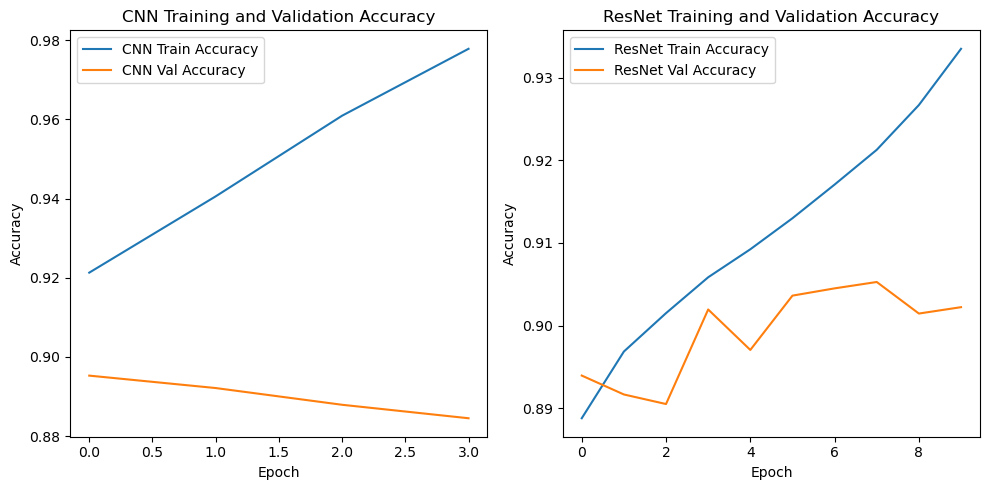

In [4]:
# Plot CNN accuracies                                                                                                                                                                                                                                                                    
plt.figure(figsize=(10, 5))                                          
plt.subplot(1, 2, 1)
plt.plot(cnn_train_accuracies, label='CNN Train Accuracy')                                                        
plt.plot(cnn_val_accuracies, label='CNN Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('CNN Training and Validation Accuracy')
plt.legend()

# Plot ResNet accuracies
plt.subplot(1, 2, 2)
plt.plot(resnet_train_accuracies, label='ResNet Train Accuracy')
plt.plot(resnet_val_accuracies, label='ResNet Val Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('ResNet Training and Validation Accuracy')
plt.legend() 

plt.tight_layout()
plt.show()

In [ ]:
# Plot VGG16 accuracies
plt.figure(figsize=(10, 5))
plt.plot(vgg16_train_accuracies, label='Train Accuracy')
plt.plot(vgg16_val_accuracies, label='Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy per Epoch')
plt.legend()
plt.show()                    

______________________________________________________________________________

## Try an approach other than DL approaches and see the difference - Logistic Regression

#### Prepare the Data for it

In [ ]:
def extract_features(image_path):
    image = cv2.imread(image_path)
    image = cv2.resize(image, (128, 128))  # Resize image
    return image.flatten()

features = np.array([extract_features(path) for path in df['image_path']])
labels = df.iloc[:, 1:].values

X_train, X_test, y_train, y_test = train_test_split(features, labels, test_size=0.2, random_state=42)

# Convert multi-labels to a single multi-label binary vector
y_train_binary = np.array([np.argmax(labels) for labels in y_train])

### Fit Dataset Batches to the Model

In [ ]:
batch_size = 1000

# Shuffle the data
X_train_shuffled, y_train_shuffled = shuffle(X_train, y_train_binary, random_state=42)

# Determine the number of batches
num_batches = len(X_train) // batch_size

# Train the model on each batch
for i in range(num_batches):
    start_idx = i * batch_size
    end_idx = (i + 1) * batch_size
    X_batch = X_train_shuffled[start_idx:end_idx]
    y_batch = y_train_shuffled[start_idx:end_idx]
    
    print(f"Fitting batch {i+1}...")
    logreg.fit(X_batch, y_batch)
    print(f"Batch {i+1} fitted successfully.")

# Train the model on the remaining data (if any)
if len(X_train) % batch_size != 0:
    print(f"Fitting batch {num_batches+1} (remaining data)...")
    logreg.fit(X_train_shuffled[num_batches * batch_size:], y_train_shuffled[num_batches * batch_size:])
    print(f"Batch {num_batches+1} fitted successfully.")

### Evaluate the Model - Logistic Regression

In [ ]:
# Define batch size for testing
test_batch_size = 1000
y_test_binary = np.array([np.argmax(labels) for labels in y_test])

# Shuffle the test data
X_test_shuffled, y_test_shuffled = shuffle(X_test, y_test_binary, random_state=42)

# Determine the number of batches for testing
num_test_batches = len(X_test) // test_batch_size

# Initialize empty array for predicted labels
y_pred_test = np.array([])

# Predict on each batch of test data
for i in range(num_test_batches):
    start_idx = i * test_batch_size
    end_idx = (i + 1) * test_batch_size
    X_test_batch = X_test_shuffled[start_idx:end_idx]
    y_pred_test_batch = logreg.predict(X_test_batch)
    y_pred_test = np.concatenate((y_pred_test, y_pred_test_batch))

# Predict on the remaining test data (if any)
if len(X_test) % test_batch_size != 0:
    remaining_test_data = X_test_shuffled[num_test_batches * test_batch_size:]
    y_pred_test_remaining = logreg.predict(remaining_test_data)
    y_pred_test = np.concatenate((y_pred_test, y_pred_test_remaining))

# Calculate evaluation metrics for the test set
# Calculate evaluation metrics for the test set
precision_test = precision_score(y_test_binary, y_pred_test, average='micro')
recall_test = recall_score(y_test_binary, y_pred_test, average='micro')
f1_test = f1_score(y_test_binary, y_pred_test, average='micro')

print(f"Test Set Precision (Micro Average): {precision_test}")
print(f"Test Set Recall (Micro Average): {recall_test}")
print(f"Test Set F1 Score (Micro Average): {f1_test}")

-------------------------------------------------------------------------------------------------

## **Model               -    Train Accuracy    -    Testing Accuracy**
* ##  CNN                          98%                       88%
* ##  ResNet                       94%                       90%
* ##  VGG16                         -                         -
* ##  Linear Regression            58%                       10%

# The Best Model would Be **ResNet** with accuracy 90%